# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import ast
import re
from datetime import datetime
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# фиксируем так же "текущую дату", чтобы эксперименты с дельтой относительно
# текущего времени так же были воспроизводимы
CURRENT_DATE = pd.to_datetime('2020-12-08')

In [4]:
# Директория с данными
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'

In [5]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [6]:
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [8]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [10]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [11]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [13]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [15]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
3565,id_3565,London,['Indian'],16229.0,NaN,2.0,"[['Dinner with a mate', 'WORST Indian ever'], ...",/Restaurant_Review-g186338-d5489885-Reviews-In...,d5489885,0,0.0
14007,id_7618,Paris,NaN,7619.0,NaN,6.0,"[['Awesome!!'], ['07/25/2016']]",/Restaurant_Review-g187147-d9807467-Reviews-La...,d9807467,1,4.5
1895,id_1895,Hamburg,NaN,1919.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187331-d12825112-Reviews-P...,d12825112,0,0.0
11028,id_16353,London,"['Fast Food', 'Halal']",16370.0,NaN,NaN,"[['THE WINGS DISASTER'], ['05/18/2017']]",/Restaurant_Review-g186338-d7274076-Reviews-Or...,d7274076,1,1.0
27773,id_5760,Madrid,"['International', 'Spanish', 'Fusion']",5763.0,$$ - $$$,NaN,"[[], []]",/Restaurant_Review-g187514-d12805951-Reviews-A...,d12805951,1,4.0


Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   

## 1. Предобработка признаков и обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

### 1.1 Признак Restaurant_id

In [16]:
# Сначала создадим функцию для быстрого получения информации по столбцу:
def col_overview(x):
    print('Количество пропусков: {},'.format(x.isnull().sum()))
    print('{},'.format(x.describe()))
    print('Распределение:\n{},'.format(x.value_counts()))

In [17]:
col_overview(data.Restaurant_id)

Количество пропусков: 0,
count      50000
unique     13094
top       id_436
freq          19
Name: Restaurant_id, dtype: object,
Распределение:
id_436      19
id_871      19
id_227      19
id_633      19
id_585      18
            ..
id_13636     1
id_11782     1
id_13202     1
id_11859     1
id_9983      1
Name: Restaurant_id, Length: 13094, dtype: int64,


Выводы по признаку:
* по признаку нет пропусков
* уникальных значений всего 13094
* скорее всего часто встречающиеся рестораны являются сетевыми ресторанами

### 1.2 Признак City

In [18]:
col_overview(data.City)

Количество пропусков: 0,
count      50000
unique        31
top       London
freq        7193
Name: City, dtype: object,
Распределение:
London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64,


Выводы по признаку:
Самое большое количество ресторанов в Лондоне, самое меньшее в Любляне. Пропусков по признаку нет.Всего в датасете представлен 31 город. Дублей, связанных с неправильным названием городов тоже не найдено

### 1.3 Признак Cuisine Style

In [19]:
#Введем признак по отсуствию данных
data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')

In [20]:
# Так как по одному ресторану в датасете приведены несколько записей, то можно 
# попробовать заменить уже имеющимися данными по этим ресторанам
data['Cuisine Style'] = data.sort_values('Cuisine Style').groupby('Restaurant_id')['Cuisine Style'].ffill()
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Cuisine_Style_isNAN
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0


In [21]:
#Проверяем сколько еще осталось пропусков в столбце
data['Cuisine Style'].isnull().sum()

1662

In [22]:
# Заменим оставшиеся пропуски самым частым значением кухни:
data['Cuisine Style']= data['Cuisine Style'].dropna().map(lambda x: re.sub(r"[\]'[]", '', x))
cuisine_series = pd.Series(data['Cuisine Style'].str.cat(sep = ', ').split(', '))
data['Cuisine Style'] = data['Cuisine Style'].fillna(cuisine_series.value_counts().index[0])

In [23]:
data['Cuisine Style'] = data['Cuisine Style'].str.strip(',')

In [24]:
# Снова проверим наличие пропусков
data['Cuisine Style'].isnull().sum()

0

In [25]:
# Запишем новый признак: количество типов кухни
data['Cuisine_Style_Count'] = data['Cuisine Style'].apply(lambda x: len(x))
# Наиболее популярные кухни
CS_top5 = set(data['Cuisine Style'].explode().value_counts()[:5].index)

Выводы по признаку:
По признаку имеются пропуски, также результаты приведены в качестве списков из разных видов кухонь.
По одной сети ресторанов могут быть разные виды кухонь в разных городах. 
На будущее: нужно проверить кухни по ресторанам и взять те, которые встречаются во всех ресторанах.

### 1.4 Признак Price range

In [26]:
col_overview(data['Price Range'])

Количество пропусков: 17361,
count        32639
unique           3
top       $$ - $$$
freq         23041
Name: Price Range, dtype: object,
Распределение:
$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64,


In [27]:
# Определяем пропорции значений
data['Price Range'].value_counts(normalize=True)

$$ - $$$    0.705935
$           0.239468
$$$$        0.054597
Name: Price Range, dtype: float64

В данных имеется много пропусков. Попробуем заменить их на основе распределения значений признака

In [28]:
data['Price Range'] = data['Price Range'].fillna(pd.Series(np.random.choice(['$$$$', '$', '$$ - $$$'], 
                                                      p=[0.05, 0.24, 0.71], size=len(data))))

In [29]:
data['Price Range'].isnull().sum()

0

Выводы по признаку:
По признаку много пропусков (35%). Всего уникальных значений -3.

### 1.5 Признак Number of Reviews

In [30]:
col_overview(data['Number of Reviews'])

Количество пропусков: 3200,
count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64,
Распределение:
2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: Number of Reviews, Length: 1573, dtype: int64,


Количество пропусков в признаке- 3200. Предположим, что NaN в number_of_reviews - это отсутствие комментариев, заменим на 0. 

In [31]:
# в признаке 6% пропущенных значений - скорее всего, не было комментариев
# сохраним эту информацию
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [32]:
# Далее заполняем пропуски 0
# data['Number of Reviews'].fillna(0, inplace=True)
data['Number of Reviews'] = data['Number of Reviews'].fillna(
    data.groupby('City')['Number of Reviews'].transform('mean'))

### 1.6 Признак Reviews

Посмотрим сколько пустых значений есть в столбце:

In [33]:
rev=data[data['Reviews'].isnull()]
rev.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Cuisine_Style_isNAN,Cuisine_Style_Count,Number_of_Reviews_isNAN
8168,id_8168,Lisbon,Vegetarian Friendly,3389.0,$$ - $$$,2.000000,NaN,/Restaurant_Review-g189158-d12683988-Reviews-O...,d12683988,0,0.0,1,19,0
9608,id_9608,Vienna,Vegetarian Friendly,1779.0,$$ - $$$,80.535094,NaN,/Restaurant_Review-g190454-d12605368-Reviews-R...,d12605368,0,0.0,1,19,1


Всего два значения, хотя есть много записей в виде пустых списков [[],[]]

In [34]:
# Приведем пропуски к единому формату:
data['Reviews'] = data['Reviews'].fillna('[[], []]')

In [35]:
# Создадим функцию для разделения отзывов от дат
def return_review_date(row, mode = 'newest'):
    '''replacing nan values from text reviews cause of ast.literal_eval error
       Function returns NaN if reviews are empty
       Function returns one date if it is only one review
       Function returns newest/oldest review according to mode'''
    str_review = ast.literal_eval(str(row['Reviews']).replace('nan','0'))
    if str_review == [[], []]:
        return 'NaN'
    elif len(str_review[1]) == 1:
        return(datetime.strptime(str_review[1][0],'%m/%d/%Y'))
    else:
        first_review_time = datetime.strptime(str_review[1][0],'%m/%d/%Y')
        second_review_time = datetime.strptime(str_review[1][1],'%m/%d/%Y')
        if mode == 'newest':
            return max(second_review_time, first_review_time)
        else:
            return min(second_review_time, first_review_time)

In [36]:
# Получим новые столбцы с датами применим функцию:
data['recent_review_date'] = data.apply(lambda row:return_review_date(row, mode='newest'), axis=1)
data['old_review_date'] = data.apply(lambda row:return_review_date(row, mode='eldest'), axis=1)

In [37]:
# создадим признак для тех ресторанов, у которых нет обзоров вообще
data['Reviews_is_nan'] = pd.isna(data['recent_review_date']).astype('float64')

In [38]:
# посмотрим на дату самого свежего обзора, предположим, что тогда датасет и собирался
most_recent_review_date = data['recent_review_date'].max()
most_recent_review_date

Timestamp('2018-02-26 00:00:00')

In [39]:
# посмотрим на дату самого старого обзора, учтем что Tripadviser был создан в 2000 году
oldest_review_date = data['old_review_date'].min()
oldest_review_date

Timestamp('2004-04-21 00:00:00')

In [40]:
# Посчитаем разницу в днях между обзорами
data['Days_between_reviews'] = (data['recent_review_date'] - data['old_review_date']).dt.days

In [41]:
data['Days_between_reviews'].max()

3296.0

In [42]:
# Посмотрим на самую максимальную разницу
data[data['Days_between_reviews']==3296]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Cuisine_Style_isNAN,Cuisine_Style_Count,Number_of_Reviews_isNAN,recent_review_date,old_review_date,Reviews_is_nan,Days_between_reviews
1966,id_1966,Helsinki,"Mediterranean, Greek, Vegetarian Friendly",1117.0,$$ - $$$,2.0,"[['Mixed feelings', 'Bear & Karaoke place.'], ...",/Restaurant_Review-g189934-d1199811-Reviews-Ba...,d1199811,0,0.0,1,41,0,2017-11-14,2008-11-05,0.0,3296.0


по этому ресторану самая старая дата от 2008 года

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Количество пропусков: 8114,
count                   41886
unique                   2278
top       2018-01-03 00:00:00
freq                      231
first     2004-04-21 00:00:00
last      2018-02-26 00:00:00
Name: old_review_date, dtype: object,
Распределение:
2018-01-03    231
2017-12-30    194
2018-01-04    191
2018-01-01    190
2017-12-22    187
             ... 
2013-08-25      1
2010-05-18      1
2009-08-20      1
2013-01-22      1
2012-03-30      1
Name: old_review_date, Length: 2278, dtype: int64,


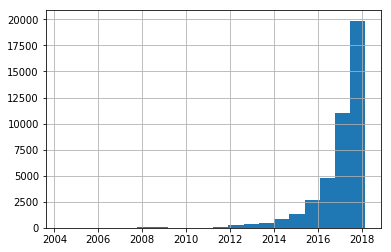

In [43]:
# Посмотрим, как распределены даны по датам для определения выбросов
data['old_review_date'].hist(bins=20)
col_overview(data['old_review_date'])

Количество пропусков: 8114,
count                   41886
unique                   1976
top       2018-01-07 00:00:00
freq                      646
first     2004-04-21 00:00:00
last      2018-02-26 00:00:00
Name: recent_review_date, dtype: object,
Распределение:
2018-01-07    646
2018-01-03    568
2018-01-06    522
2018-01-04    492
2018-01-08    477
             ... 
2014-09-22      1
2013-08-07      1
2013-07-27      1
2014-03-05      1
2014-07-12      1
Name: recent_review_date, Length: 1976, dtype: int64,


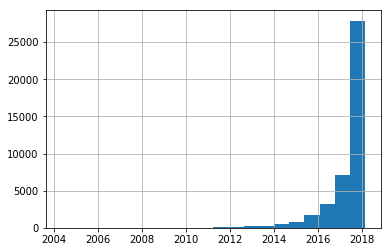

In [44]:
data['recent_review_date'].hist(bins=20)
col_overview(data['recent_review_date'])

In [45]:
#Заполним пропуски самыми частыми значениями из каждого столбца
data['recent_review_date'] = data['recent_review_date'].fillna(
    data['recent_review_date'].mode().iloc[0])
data['old_review_date'] = data['old_review_date'].fillna(
    data['old_review_date'].mode().iloc[0])

In [46]:
#также создадим новый признак: кол-во дней до самого нового отзыва
data['days_to_most_recent_review'] = (most_recent_review_date - 
                                      data['recent_review_date']).dt.days

In [47]:
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Cuisine_Style_isNAN,Cuisine_Style_Count,Number_of_Reviews_isNAN,recent_review_date,old_review_date,Reviews_is_nan,Days_between_reviews,days_to_most_recent_review
0,id_0,Paris,"Bar, Pub",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,8,0,2018-01-07,2018-01-03,1.0,NaN,50
1,id_1,Helsinki,"European, Scandinavian, Gluten Free Options, V...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,79,0,2017-12-05,2017-10-29,0.0,37.0,83
2,id_2,Edinburgh,Vegetarian Friendly,810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,19,0,2017-12-28,2017-12-06,0.0,22.0,60
3,id_3,London,"Italian, Mediterranean, European, Vegetarian F...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,74,0,2017-12-06,2017-11-22,0.0,14.0,82
4,id_4,Bratislava,"Italian, Mediterranean, European, Seafood, Veg...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,83,0,2018-02-08,2018-01-24,0.0,15.0,18


In [48]:
#Заполним пустые списки в Review и почистим формат столбца  
data['Reviews'] = data['Reviews'].astype(str).apply(lambda x: x.replace('[[], []]', 'no data'))
data['Reviews'] = data['Reviews'].map(lambda x: re.sub(r"[\]'[]", '', x))
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Cuisine_Style_isNAN,Cuisine_Style_Count,Number_of_Reviews_isNAN,recent_review_date,old_review_date,Reviews_is_nan,Days_between_reviews,days_to_most_recent_review
0,id_0,Paris,"Bar, Pub",12963.0,$$ - $$$,4.0,no data,/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,8,0,2018-01-07,2018-01-03,1.0,NaN,50
1,id_1,Helsinki,"European, Scandinavian, Gluten Free Options, V...",106.0,$$ - $$$,97.0,"Very good reviews!, Fine dining in Hakaniemi, ...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,79,0,2017-12-05,2017-10-29,0.0,37.0,83
2,id_2,Edinburgh,Vegetarian Friendly,810.0,$$ - $$$,28.0,"Better than the Links, Ivy Black, 12/28/2017, ...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,19,0,2017-12-28,2017-12-06,0.0,22.0,60
3,id_3,London,"Italian, Mediterranean, European, Vegetarian F...",1669.0,$$$$,202.0,"Most exquisite, Delicious and authentic, 12/06...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,74,0,2017-12-06,2017-11-22,0.0,14.0,82
4,id_4,Bratislava,"Italian, Mediterranean, European, Seafood, Veg...",37.0,$$$$,162.0,"Always the best in bratislava, Very good but p...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,83,0,2018-02-08,2018-01-24,0.0,15.0,18


Выводы по признаку:
В признаке есть пропуски. В значениях приведены 2 отзыва и 2 даты отзыва в качестве строковых данных.

### 1.7 Признак Ranking

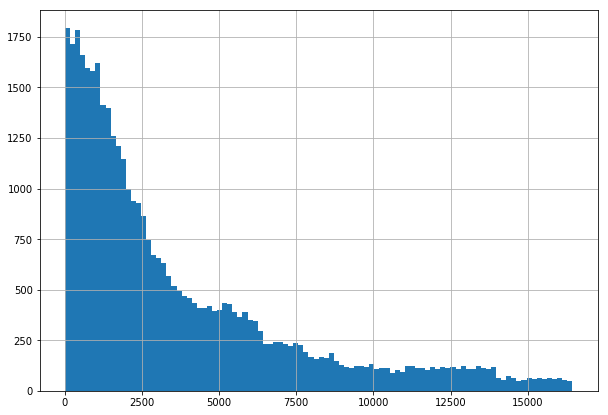

In [49]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

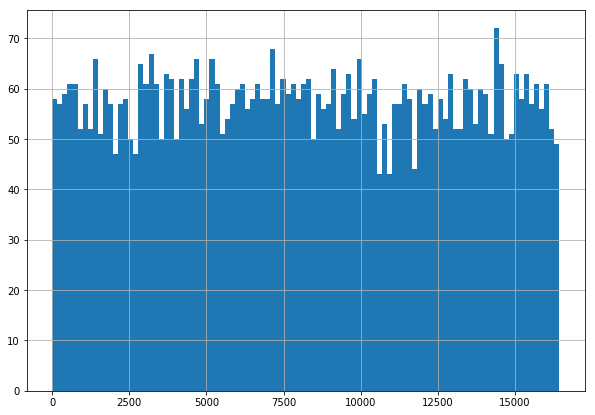

In [50]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

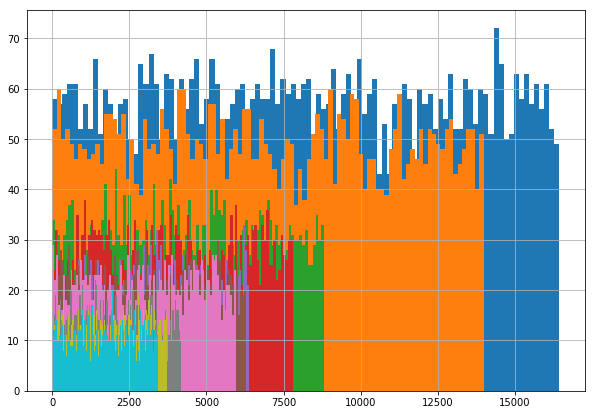

In [51]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 

### 1.8 Целевая переменная Rating

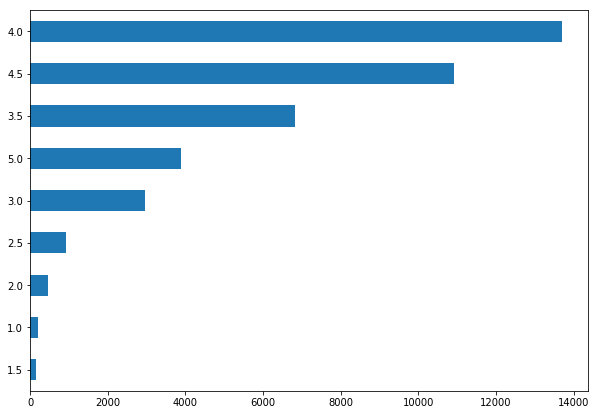

In [52]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

Посмотрим распределение целевой переменной относительно признака

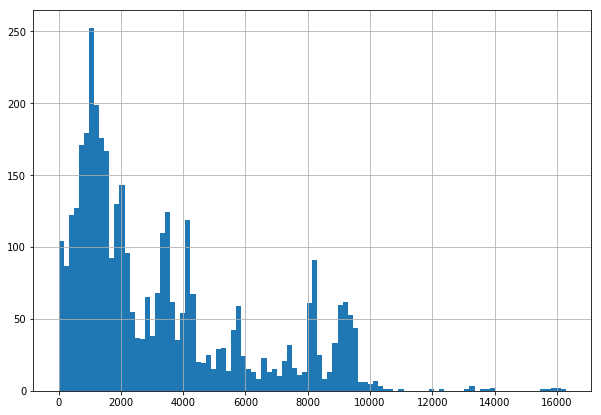

In [53]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

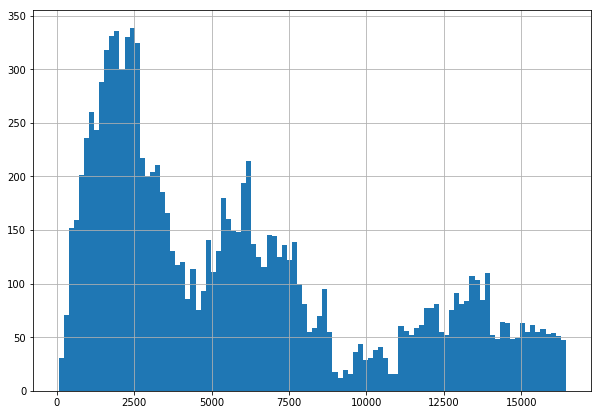

In [54]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

In [55]:
# Найдем число ресторанов в кажом городе и относительный ранк на этой основе
data['restaurants_in_city'] = data['City'].map(data['City'].value_counts().to_dict())
data['W_Ranking'] = data['Ranking'] / data['restaurants_in_city']
data['W_Number_of_Reviews'] = data['Number of Reviews'] / data['restaurants_in_city']

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [56]:
data.nunique(dropna=False)

Restaurant_id                 13094
City                             31
Cuisine Style                 10731
Ranking                       12975
Price Range                       3
Number of Reviews              1604
Reviews                       41857
URL_TA                        49963
ID_TA                         49963
sample                            2
Rating                           10
Cuisine_Style_isNAN               2
Cuisine_Style_Count             140
Number_of_Reviews_isNAN           2
recent_review_date             1976
old_review_date                2278
Reviews_is_nan                    2
Days_between_reviews           1311
days_to_most_recent_review     1976
restaurants_in_city              31
W_Ranking                     49655
W_Number_of_Reviews            9766
dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.

### 2.1 Признак "Price Range"

In [57]:
data['Price Range'].value_counts()

$$ - $$$    35406
$           11943
$$$$         2651
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3

In [58]:
data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')
data['Price Range'] = data['Price Range'].map({'$': 10,'$$ - $$$': 50,
            '$$$$': 200,np.NaN: 50,   # неизвестные примем, как из среднего диапазона
        })

In [59]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Number_of_Reviews_isNAN,recent_review_date,old_review_date,Reviews_is_nan,Days_between_reviews,days_to_most_recent_review,restaurants_in_city,W_Ranking,W_Number_of_Reviews,Price_Range_isNAN
19562,id_4872,Barcelona,"Pizza, Fast Food",4873.0,10,38.0,"Comics and lunch!, Great place for cheap tasty...",/Restaurant_Review-g187497-d10039385-Reviews-G...,d10039385,1,...,0,2017-08-29,2017-04-17,0.0,134.0,181,3395,1.435346,0.011193,0
30664,id_1833,Lyon,Pizza,1834.0,50,13.0,no data,/Restaurant_Review-g1080938-d8509698-Reviews-L...,d8509698,1,...,0,2018-01-07,2018-01-03,1.0,NaN,50,1126,1.628774,0.011545,0
8567,id_8567,Paris,Indian,9094.0,50,7.0,"Very tasty and friendly 😃, The best Indian foo...",/Restaurant_Review-g187147-d7284685-Reviews-Al...,d7284685,0,...,0,2017-12-07,2014-11-25,0.0,1108.0,81,6108,1.488867,0.001146,0
36219,id_847,Barcelona,"American, Fast Food, European",848.0,50,154.0,"""One of the best burgers Ive ever had!"", A fea...",/Restaurant_Review-g187497-d8027248-Reviews-Ni...,d8027248,1,...,0,2017-12-15,2017-10-27,0.0,49.0,73,3395,0.249779,0.045361,0
2159,id_2159,Amsterdam,"Italian, Mediterranean, Pub",1947.0,50,11.0,"Really great little pub, A most welcome return...",/Restaurant_Review-g188590-d8511126-Reviews-Bu...,d8511126,0,...,0,2017-02-07,2017-01-19,0.0,19.0,384,1372,1.419096,0.008017,0


### 2.2 Признак "Cuisine Style"

In [60]:
# Делаем dummies из популярных кухонь
values = data['Cuisine Style']
mask = values.isin(CS_top5)
data=data.join(pd.get_dummies(values[mask]))

### 2.3 Признак "Reviews"

Создадим словари с фразами и словами из Review:

In [61]:
great = ["Delicious", "Great", "tasteful","Awesome", "Must Visit", "Brilliant","delicious", "great","favourites", "Recommend it", "EXCELLENT", "Perfect", "tasty", "COMPLETELY REAL", "outstanding", "Favourite", "Wonderful", "fantastic", "Fantastic", "Superb", "Amazing",
         "BEST", "wonderful", "perfect", "Best", "best", "AMAZING","Amazing", "favorite", "Excellent", "excellent", "GREAT", "Cool", "cool", "Delightful"]
good = ["Good", "good", "Nice", "average","Pleasant", "surprise","hospitable", "Cosy", "Soso", "Average", "Beautiful", "nice", "No bad", "Friendly", "friendly", "charm",
        "no bad", "Not bad", "pleasant","Welcoming", "is ok", "OK", "not bad", "relaxing", "Relaxing", "Alright", "Love", "Tasty"]
bad = ["No", "no", "Mediocre", "not", "Not", "poor", "bad", "Worst", "Bad", "Shameful",
       "Too busy", "appalling", "rude", "Dirty", "Underwhelmed","Awful", "hidden gem", "Horrible", "horrible", "Disappointed", "Don't eat", "Avoid", "could improve", "Dissapointed"]

In [62]:
def setMarksToReview(s):
    mark = 0
    for st in s:
     #   print(s)
        if "no data" in s:
            break

        for g in good:
            if g in s:
                #    print(g)
                mark = 3.5
                break
        for b in bad:
            if b in s:
                #    print(b)
                mark = 0
                break
        for gr in great:
            if gr in s:
              #  print(gr)
                mark = 5
                break
    else:
        return (mark)


data['Reviews_eval'] = data.Reviews.apply(lambda x: setMarksToReview(x))
data = data.fillna("0")

In [63]:
data.sample(10)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,restaurants_in_city,W_Ranking,W_Number_of_Reviews,Price_Range_isNAN,French,Italian,Pizza,Spanish,Vegetarian Friendly,Reviews_eval
46149,id_2449,Amsterdam,"Steakhouse, Brazilian, Barbecue, Grill",2455.0,50,3.0,"Courtesy, Coffee, Tea, Chocolate and Rembrandt...",/Restaurant_Review-g188590-d11756568-Reviews-S...,d11756568,1,...,1372,1.789359,0.002187,0,0,0,0,0,0,0
37495,id_699,Brussels,"Belgian, European, International",700.0,200,139.0,"The Tram experience is really an experienc...,...",/Restaurant_Review-g188644-d2650507-Reviews-Th...,d2650507,1,...,1314,0.532725,0.105784,0,0,0,0,0,0,5
46378,id_2263,Hamburg,Thai,2267.0,50,2.0,no data,/Restaurant_Review-g187331-d5520110-Reviews-As...,d5520110,1,...,1186,1.911467,0.001686,0,0,0,0,0,0,0
9121,id_9121,Athens,Vegetarian Friendly,1056.0,10,3.0,"nice juice bar!, Fruit paradise, 08/29/2017, 0...",/Restaurant_Review-g189400-d8803954-Reviews-Ju...,d8803954,0,...,776,1.360825,0.003866,0,0,0,0,0,1,3.5
19186,id_47,Milan,"Steakhouse, Latin, Barbecue, Argentinean, Sout...",48.0,200,2541.0,"Meat eaters paradise, One of the best steaks, ...",/Restaurant_Review-g187849-d2005950-Reviews-El...,d2005950,1,...,2694,0.017817,0.943207,0,0,0,0,0,0,5
46339,id_15453,London,Indian,15465.0,10,10.0,"Awful Awful, Brilliant Curry House. Delicious ...",/Restaurant_Review-g186338-d5122814-Reviews-Hi...,d5122814,1,...,7193,2.150007,0.001390,0,0,0,0,0,0,5
25842,id_1739,Brussels,"French, Belgian, European",1740.0,10,11.0,"good little local cafe, ""Its OK - dont expect ...",/Restaurant_Review-g1136497-d5895712-Reviews-L...,d5895712,1,...,1314,1.324201,0.008371,0,0,0,0,0,0,3.5
18802,id_2355,Paris,"Mediterranean, European, Greek, Vegetarian Fri...",2356.0,50,277.0,"Great Greek food., Tasty food, tender souvlaki...",/Restaurant_Review-g187147-d833462-Reviews-Les...,d833462,1,...,6108,0.385724,0.045350,0,0,0,0,0,0,5
29567,id_1740,Rome,"Italian, Vegetarian Friendly",1741.0,50,145.0,"Perfect food, wine and service, 06/13/2016",/Restaurant_Review-g187791-d8637699-Reviews-Os...,d8637699,1,...,2589,0.672460,0.056006,0,0,0,0,0,0,5
5962,id_5962,Berlin,"British, Vegetarian Friendly",2640.0,50,9.0,"Cool cocktail bar, Insider *****, 09/26/2017, ...",/Restaurant_Review-g187323-d7009281-Reviews-Fa...,d7009281,0,...,2705,0.975970,0.003327,0,0,0,0,0,0,5


### 2.5 Признак "City"

In [64]:
#Создаем dummy variables для признака
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=False)

In [65]:
#Вариант - выбрать только топ 10 городов
#City_top10 = set(data['City'].value_counts()[:10].index)
#values = data['City']
#mask = values.isin(City_top10)
#data=data.join(pd.get_dummies(values[mask]))

In [66]:
data.fillna(0)
data.sample(20)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
38859,id_2733,"Vietnamese, Vegetarian Friendly, Vegan Options",2735.0,10,80.535094,no data,/Restaurant_Review-g190454-d11860832-Reviews-K...,d11860832,1,4.0,...,0,0,0,0,0,0,0,1,0,0
1689,id_1689,Spanish,6042.0,50,13.000000,"New Name, 03/01/2016",/Restaurant_Review-g187497-d3360202-Reviews-El...,d3360202,0,0.0,...,0,0,0,0,0,0,0,0,0,0
19635,id_4656,"Mediterranean, Spanish",4657.0,10,95.000000,"Loved the Pork, Cheap and great quality. A rar...",/Restaurant_Review-g187497-d3385593-Reviews-El...,d3385593,1,3.5,...,0,0,0,0,0,0,0,0,0,0
46995,id_4055,"European, Czech",4069.0,50,124.377722,no data,/Restaurant_Review-g274707-d4769756-Reviews-Si...,d4769756,1,2.0,...,0,0,0,0,1,0,0,0,0,0
41791,id_6192,Italian,6194.0,50,6.000000,"A good italina restaurant, 01/05/2012",/Restaurant_Review-g187323-d1037157-Reviews-Li...,d1037157,1,3.0,...,0,0,0,0,0,0,0,0,0,0
29149,id_530,"Austrian, European, German, Bar, Central Europ...",531.0,50,118.000000,"Good Austrian fare, Nice Austrian food for goo...",/Restaurant_Review-g190454-d4829669-Reviews-Er...,d4829669,1,4.0,...,0,0,0,0,0,0,0,1,0,0
30600,id_5059,Italian,5060.0,50,11.000000,"Great little place to eat, Excellent food, 04/...",/Restaurant_Review-g187497-d5777493-Reviews-Ma...,d5777493,1,4.0,...,0,0,0,0,0,0,0,0,0,0
4607,id_4607,Italian,2438.0,50,15.000000,"Cappy place, Long waiting!!, 08/01/2017, 03/25...",/Restaurant_Review-g189852-d6206432-Reviews-Pa...,d6206432,0,0.0,...,0,0,0,0,0,0,1,0,0,0
6803,id_6803,"Bar, Pub",4090.0,50,56.000000,"Proper boozer, Nice pub, nice service, nice cr...",/Restaurant_Review-g186338-d3228447-Reviews-Th...,d3228447,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2709,id_2709,"Italian, Pizza, European, Vegetarian Friendly",2562.0,10,77.649387,"Nice Place, 10/29/2017",/Restaurant_Review-g187309-d13076001-Reviews-F...,d13076001,0,0.0,...,1,0,0,0,0,0,0,0,0,0


### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

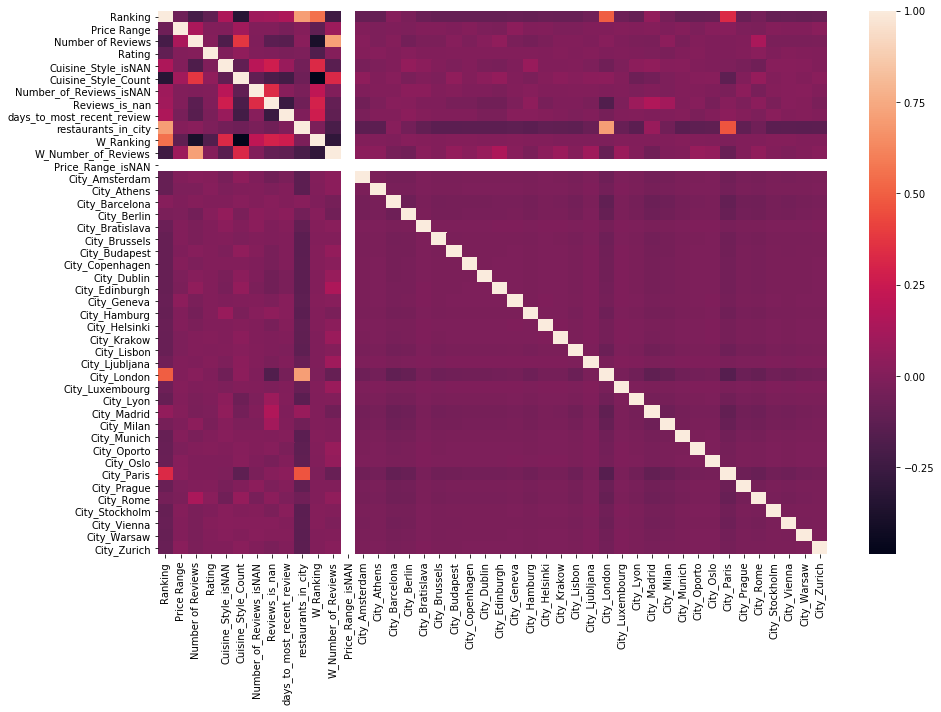

In [67]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [68]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

#data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
#data.info()

In [69]:
data.drop(columns=['Restaurant_id', 'Cuisine Style', 'Ranking', 'Reviews', 'URL_TA', 'ID_TA',
                   'recent_review_date','old_review_date'],inplace=True)

In [70]:
#data = data.select_dtypes(exclude=['object','datetime64[ns]'])

#### Запускаем и проверяем что получилось

In [71]:
df_preproc = data
df_preproc.sample(10)

,Price Range,Number of Reviews,sample,Rating,Cuisine_Style_isNAN,Cuisine_Style_Count,Number_of_Reviews_isNAN,Reviews_is_nan,Days_between_reviews,days_to_most_recent_review,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
21526,50,1803.000000,1,4.0,0,93,0,0.0,84,56,...,0,0,0,0,0,1,0,0,0,0
6336,50,497.000000,0,0.0,0,43,0,0.0,22,85,...,0,0,0,1,0,0,0,0,0,0
14527,50,37.000000,1,4.0,0,16,0,0.0,102,152,...,0,0,0,1,0,0,0,0,0,0
437,50,76.000000,0,0.0,0,43,0,0.0,41,126,...,0,0,0,0,0,0,0,1,0,0
22599,50,89.000000,1,3.0,0,6,0,0.0,101,544,...,0,0,0,1,0,0,0,0,0,0
15656,10,54.000000,1,4.0,0,27,0,0.0,181,143,...,0,0,0,0,0,0,0,0,0,0
20620,200,154.276382,1,4.0,0,6,1,1.0,0,50,...,0,0,0,0,0,0,0,0,0,0
21619,50,60.000000,1,3.5,0,26,0,0.0,193,211,...,0,0,0,1,0,0,0,0,0,0
39283,50,30.000000,1,4.0,0,10,0,0.0,560,49,...,0,0,0,0,0,0,0,0,0,0
12287,50,26.000000,1,5.0,1,30,0,1.0,0,50,...,0,0,0,0,0,0,0,0,0,0


In [72]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 51 columns):
Price Range                   50000 non-null int64
Number of Reviews             50000 non-null float64
sample                        50000 non-null int64
Rating                        50000 non-null float64
Cuisine_Style_isNAN           50000 non-null uint8
Cuisine_Style_Count           50000 non-null int64
Number_of_Reviews_isNAN       50000 non-null uint8
Reviews_is_nan                50000 non-null float64
Days_between_reviews          50000 non-null object
days_to_most_recent_review    50000 non-null int64
restaurants_in_city           50000 non-null int64
W_Ranking                     50000 non-null float64
W_Number_of_Reviews           50000 non-null float64
Price_Range_isNAN             50000 non-null uint8
French                        50000 non-null object
Italian                       50000 non-null object
Pizza                         50000 non-null object
Spanish   

In [73]:

df_preproc = df_preproc.astype({"French": float,"Italian": float,"Pizza": float,"Spanish": float,
                               "Vegetarian Friendly": float, "Days_between_reviews": float,
                                "Reviews_eval": float})
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 51 columns):
Price Range                   50000 non-null int64
Number of Reviews             50000 non-null float64
sample                        50000 non-null int64
Rating                        50000 non-null float64
Cuisine_Style_isNAN           50000 non-null uint8
Cuisine_Style_Count           50000 non-null int64
Number_of_Reviews_isNAN       50000 non-null uint8
Reviews_is_nan                50000 non-null float64
Days_between_reviews          50000 non-null float64
days_to_most_recent_review    50000 non-null int64
restaurants_in_city           50000 non-null int64
W_Ranking                     50000 non-null float64
W_Number_of_Reviews           50000 non-null float64
Price_Range_isNAN             50000 non-null uint8
French                        50000 non-null float64
Italian                       50000 non-null float64
Pizza                         50000 non-null float64
Spanis

In [74]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [75]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [76]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 50), (40000, 50), (40000, 49), (32000, 49), (8000, 49))

# Model 
Сам ML

In [77]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [78]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [79]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [80]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.202674375


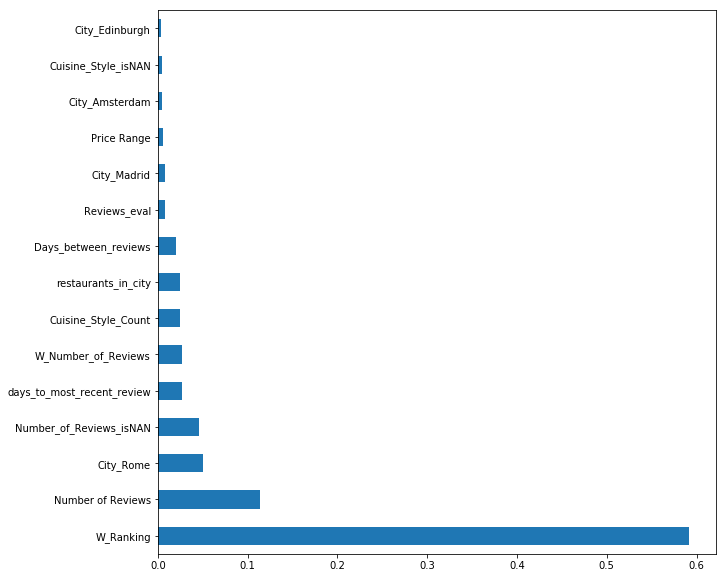

In [81]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [82]:
test_data.sample(10)

,Price Range,Number of Reviews,Rating,Cuisine_Style_isNAN,Cuisine_Style_Count,Number_of_Reviews_isNAN,Reviews_is_nan,Days_between_reviews,days_to_most_recent_review,restaurants_in_city,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
1970,50,2.000000,0.0,1,7,0,0.0,54.0,115,2705,...,0,0,0,0,0,0,0,0,0,0
5533,50,4.000000,0.0,1,19,0,1.0,0.0,50,6108,...,0,0,0,1,0,0,0,0,0,0
7784,50,232.000000,0.0,0,45,0,0.0,23.0,12,1314,...,0,0,0,0,0,0,0,0,0,0
7924,50,12.000000,0.0,0,22,0,0.0,99.0,312,3395,...,0,0,0,0,0,0,0,0,0,0
3929,50,18.000000,0.0,0,28,0,0.0,198.0,62,3395,...,0,0,0,0,0,0,0,0,0,0
7038,50,20.000000,0.0,0,9,0,0.0,0.0,560,3813,...,0,0,0,0,0,0,0,0,0,0
4917,50,6.000000,0.0,0,4,0,1.0,0.0,50,1443,...,0,0,0,0,0,0,0,1,0,0
1523,50,243.000000,0.0,0,48,0,0.0,10.0,77,7193,...,0,0,0,0,0,0,0,0,0,0
7445,50,341.000000,0.0,0,42,0,0.0,5.0,50,776,...,0,0,0,0,0,0,0,0,0,0
5553,10,127.830078,0.0,0,11,1,0.0,0.0,179,1647,...,0,0,0,0,0,0,0,0,0,0


In [83]:
test_data = test_data.drop(['Rating'], axis=1)

In [84]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [85]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [86]:
predict_submission

array([2.965, 4.31 , 4.375, ..., 3.06 , 4.505, 4.405])

In [87]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,2.965
1,id_1,4.310
2,id_2,4.375
3,id_3,4.320
4,id_4,4.425
5,id_5,4.450
6,id_6,2.795
7,id_7,2.675
8,id_8,4.145
9,id_9,4.655


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
